C:\Users\1\AppData\Local\Temp\ipykernel_2556\2309885249.py:78: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(prn_file_path, header=None, names=['Время', 'Амплитуда'], delim_whitespace=True)
C:\Users\1\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.684e+04, tolerance: 8.788e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\1\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.657e+06, tolerance: 2.819e+04
  model = cd_fast.enet_coordinate_descent(

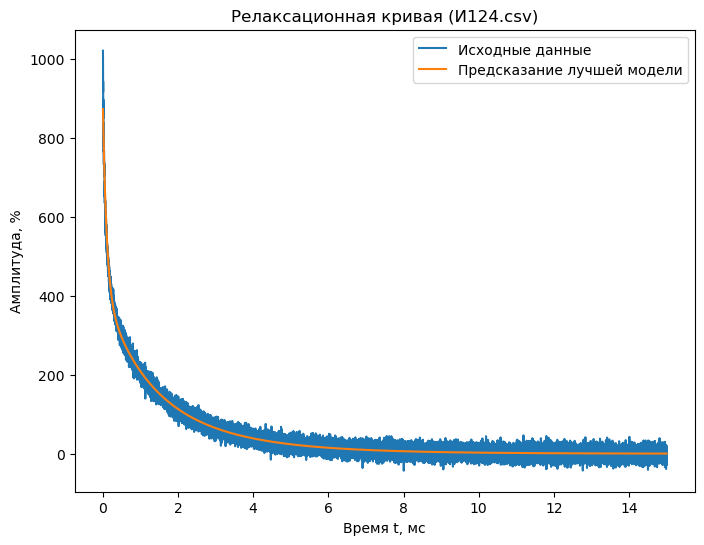

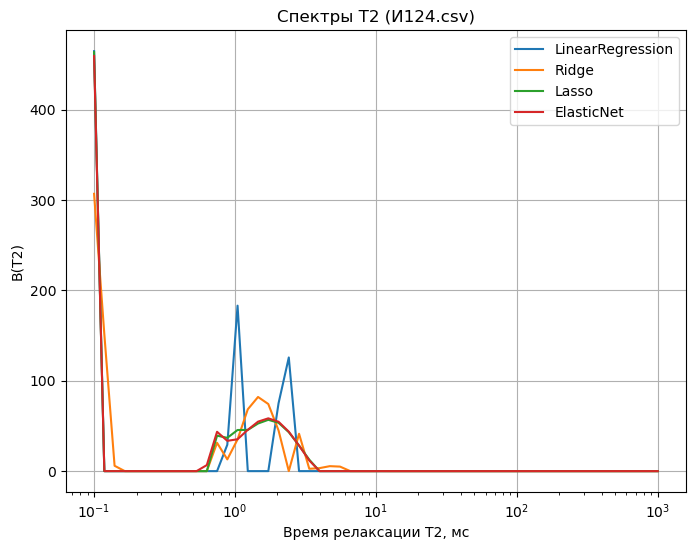

C:\Users\1\AppData\Local\Temp\ipykernel_2556\2309885249.py:78: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(prn_file_path, header=None, names=['Время', 'Амплитуда'], delim_whitespace=True)
C:\Users\1\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.289e+05, tolerance: 9.349e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\1\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e+06, tolerance: 2.265e+04
  model = cd_fast.enet_coordinate_descent(

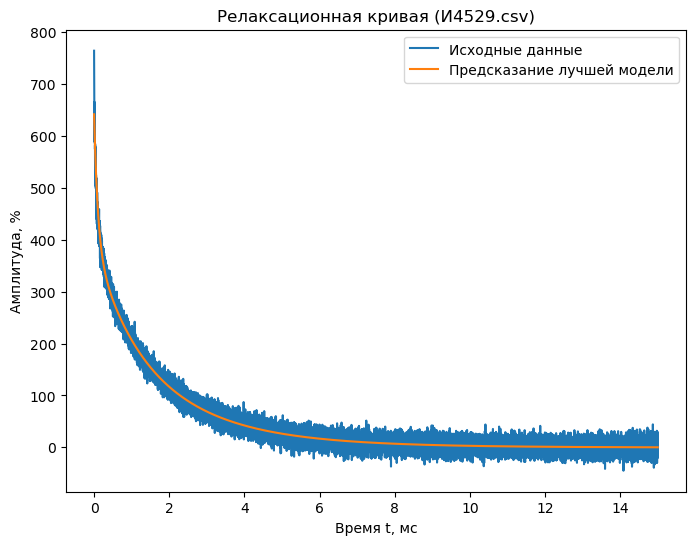

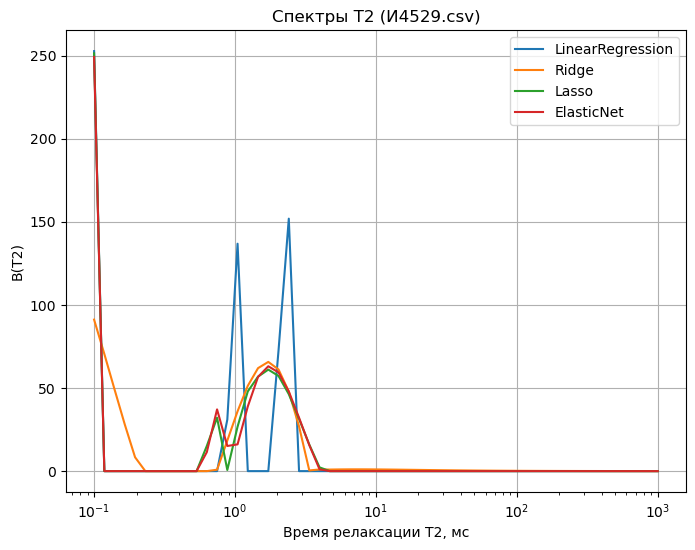

C:\Users\1\AppData\Local\Temp\ipykernel_2556\2309885249.py:78: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(prn_file_path, header=None, names=['Время', 'Амплитуда'], delim_whitespace=True)
C:\Users\1\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.423e+03, tolerance: 8.588e+01
  model = cd_fast.enet_coordinate_descent(


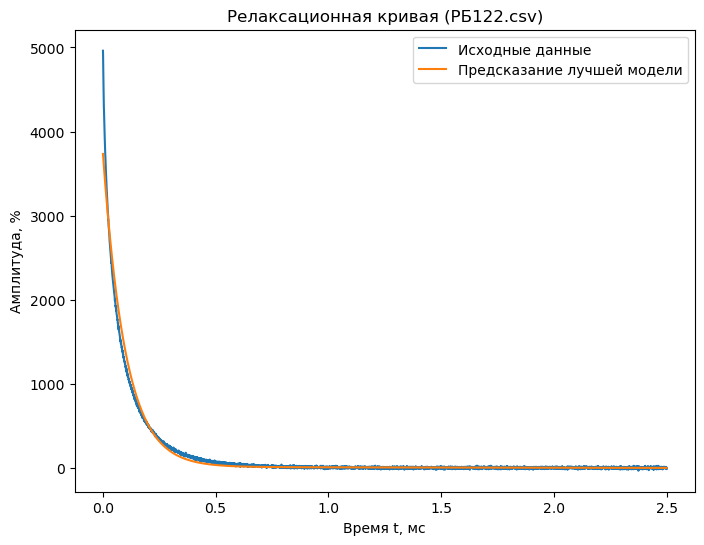

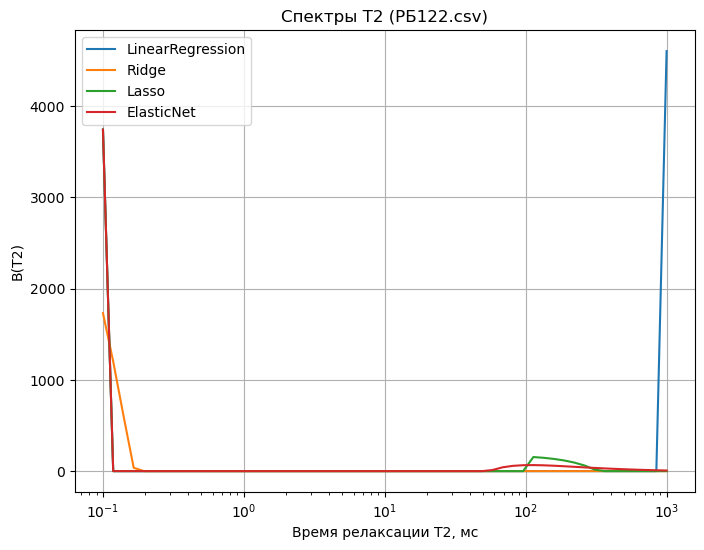

Лучшая модель для И124: ElasticNet(alpha=1e-05, l1_ratio=0.1, max_iter=3000, positive=True)
Лучшая модель для И4529: ElasticNet(alpha=1e-05, l1_ratio=0.1, max_iter=3000, positive=True)
Лучшая модель для РБ122: LinearRegression(positive=True)


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

# Функция для расчёта экспоненциальной зависимости
def nmr_decay(t, T2_values):
    """
    Возвращает матрицу значений exp(-t/T2) для набора времен t и набора T2-значений.
    Размер матрицы: (len(t), len(T2_values))
    """
    # В t может быть двумерный массив shape (N,1), сделаем одномерным
    t_flat = t.ravel()  
    # Создадим матрицу, где каждая колонка соответствует exp(-t_flat / T2_i)
    decay_matrix = np.array([np.exp(-t_flat / T2) for T2 in T2_values]).T
    return decay_matrix

# Функция для выбора лучшей модели
def select_best_model(model_results):
    """
    Принимает список кортежей вида (best_estimator, best_score) 
    и возвращает модель с максимальным best_score.
    """
    return max(model_results, key=lambda x: x[1])[0]

# Функция для подгонки нескольких моделей с помощью GridSearchCV
def fit_models(X, y, model_dict, param_dict):
    """
    На вход подаётся:
      X           - матрица признаков
      y           - целевые значения
      model_dict  - словарь {имя_модели: модель}
      param_dict  - словарь {имя_модели: параметры_грида}
    Функция возвращает список [(best_estimator, best_score), ...].
    """
    results = []
    for name, model in model_dict.items():
        grid = GridSearchCV(model, param_dict[name])
        grid.fit(X, y)
        results.append((grid.best_estimator_, grid.best_score_))
    return results

# Зададим набор T2
T2_values = np.logspace(-1, 3, 56)  # 0.1 ... 1000, 56 значений

# Создадим словарь доступных моделей
models = {
    'LR'         : LinearRegression(positive=True),
    'Ridge'      : Ridge(positive=True, max_iter=3000),
    'Lasso'      : Lasso(positive=True, max_iter=3000),
    'ElasticNet' : ElasticNet(positive=True, max_iter=3000)
}

# Зададим словарь параметров для GridSearchCV
params = {
    'LR':         {},  # для LinearRegression нет параметров регуляризации
    'Ridge':      {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 2, 5, 10]},
    'Lasso':      {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 2, 5, 10]},
    'ElasticNet': {
        'alpha':    [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 2, 5, 10],
        'l1_ratio': np.arange(0.1, 1.0, 0.1)
    }
}

# ==========
# Функция для обработки одного конкретного образца:
def process_sample(csv_file_path, T2_values, model_dict, param_dict):
    """
    Считывает данные из csv-файла по указанному пути (передаётся в аргументе),
    подбирает лучшую модель, строит графики.
    Возвращает (best_estimator, список_результатов).
    """
    # Единственная изменённая часть:
    # Вместо исходного csv_file_path напрямую формируем путь к .prn и читаем с пробелами.
    prn_file_path = "D:/Master`s Degree/2_semester/homework/" + csv_file_path.replace('.csv', '.prn')
    df = pd.read_csv(prn_file_path, header=None, names=['Время', 'Амплитуда'], delim_whitespace=True)
    
    # Переводим всё в numpy
    t = df['Время'].values.reshape(-1, 1) / 1000.0  # перевод микросекунд в миллисекунды
    amp = df['Амплитуда'].values.reshape(-1, 1)

    # Строим матрицу для регрессии
    X = nmr_decay(t, T2_values)

    # Подбираем модели
    results = fit_models(X, amp, model_dict, param_dict)
    best_model = select_best_model(results)

    # Построим график зарегистрированной релаксационной кривой и кривой, предсказанной лучшей моделью
    plt.figure(figsize=(8, 6))
    plt.plot(t, amp, label='Исходные данные')
    plt.plot(t, best_model.predict(X), label='Предсказание лучшей модели')
    plt.xlabel('Время t, мс')
    plt.ylabel('Амплитуда, %')
    plt.title(f'Релаксационная кривая ({csv_file_path})')
    plt.legend()
    plt.show()

    # Теперь построим график рассчитанного спектра T2 для всех настроенных моделей
    plt.figure(figsize=(8, 6))
    for estimator, score in results:
        coefs = estimator.coef_.ravel()
        plt.plot(T2_values, coefs, label=f"{estimator.__class__.__name__}")
    plt.xscale('log')
    plt.xlabel('Время релаксации T2, мс')
    plt.ylabel('B(T2)')
    plt.title(f'Спектры T2 ({csv_file_path})')
    plt.legend()
    plt.grid()
    plt.show()

    return best_model, results

# ==========
# Пример использования для трёх образцов (не меняем эти строки!):

# Образец "И124.csv"
best_model_i124, res_i124 = process_sample(
    csv_file_path='И124.csv',
    T2_values=T2_values,
    model_dict=models,
    param_dict=params
)

# Образец "И4529.csv"
best_model_i4529, res_i4529 = process_sample(
    csv_file_path='И4529.csv',
    T2_values=T2_values,
    model_dict=models,
    param_dict=params
)

# Образец "РБ122.csv"
best_model_rb122, res_rb122 = process_sample(
    csv_file_path='РБ122.csv',
    T2_values=T2_values,
    model_dict=models,
    param_dict=params
)

# По желанию можно посмотреть, какая лучшая модель у каждого образца:
print("Лучшая модель для И124:", best_model_i124)
print("Лучшая модель для И4529:", best_model_i4529)
print("Лучшая модель для РБ122:", best_model_rb122)
